In [1]:
import time

from sklearn.datasets import load_iris, fetch_20newsgroups, fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [2]:
# 读取数据
data = pd.read_csv("./data/FBlocation/train.csv")

print(data.head(10))
print(data.shape)
print(data.info())
# 处理数据
# 1、缩小数据,查询数据,为了减少计算时间
data = data.query("x > 1.0 &  x < 1.25 & y > 2.5 & y < 2.75")

   row_id       x       y  accuracy    time    place_id
0       0  0.7941  9.0809        54  470702  8523065625
1       1  5.9567  4.7968        13  186555  1757726713
2       2  8.3078  7.0407        74  322648  1137537235
3       3  7.3665  2.5165        65  704587  6567393236
4       4  4.0961  1.1307        31  472130  7440663949
5       5  3.8099  1.9586        75  178065  6289802927
6       6  6.3336  4.3720        13  666829  9931249544
7       7  5.7409  6.7697        85  369002  5662813655
8       8  4.3114  6.9410         3  166384  8471780938
9       9  6.3414  0.0758        65  400060  1253803156
(29118021, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29118021 entries, 0 to 29118020
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   row_id    int64  
 1   x         float64
 2   y         float64
 3   accuracy  int64  
 4   time      int64  
 5   place_id  int64  
dtypes: float64(2), int64(4)
memory usage: 1.3 GB
None


In [3]:
data.shape


(17710, 6)

In [4]:
data.describe()

,row_id,x,y,accuracy,time,place_id
count,1.771000e+04,17710.000000,17710.000000,17710.000000,17710.000000,1.771000e+04
mean,1.450569e+07,1.122538,2.632309,82.482101,397551.263128,5.129895e+09
std,8.353805e+06,0.077086,0.070144,113.613227,234601.097883,2.357399e+09
min,6.000000e+02,1.000100,2.500100,1.000000,119.000000,1.012024e+09
25%,7.327816e+06,1.049200,2.573800,25.000000,174069.750000,3.312464e+09
50%,1.443071e+07,1.123300,2.642300,62.000000,403387.500000,5.261906e+09
75%,2.163463e+07,1.190500,2.687800,75.000000,602111.750000,6.766325e+09
max,2.911215e+07,1.249900,2.749900,1004.000000,786218.000000,9.980711e+09


In [5]:
# 处理时间的数据
time_value = pd.to_datetime(data['time'], unit='s')

print(time_value.head(10))  #最大时间是1月10号

600    1970-01-01 18:09:40
957    1970-01-10 02:11:10
4345   1970-01-05 15:08:02
4735   1970-01-06 23:03:03
5580   1970-01-09 11:26:50
6090   1970-01-02 16:25:07
6234   1970-01-04 15:52:57
6350   1970-01-01 10:13:36
7468   1970-01-09 15:26:06
8478   1970-01-08 23:52:02
Name: time, dtype: datetime64[ns]


In [11]:
# 把日期格式转换成 字典格式，把年，月，日，时，分，秒转换为字典格式，
time_value = pd.DatetimeIndex(time_value)
#
print('-' * 50)
print(time_value[0:10])

--------------------------------------------------
DatetimeIndex(['1970-01-01 18:09:40', '1970-01-10 02:11:10',
               '1970-01-05 15:08:02', '1970-01-06 23:03:03',
               '1970-01-09 11:26:50', '1970-01-02 16:25:07',
               '1970-01-04 15:52:57', '1970-01-01 10:13:36',
               '1970-01-09 15:26:06', '1970-01-08 23:52:02'],
              dtype='datetime64[ns]', name='time', freq=None)


In [7]:
print('-' * 50)
# 构造一些特征，执行的警告是因为我们的操作是复制，loc是直接放入
print(type(data))
# data['day'] = time_value.day
# data['hour'] = time_value.hour
# data['weekday'] = time_value.weekday
#日期，是否是周末，小时对于个人行为的影响是较大的(例如吃饭时间去饭店，看电影时间去电影院等),所以才做下面的处理
data.insert(data.shape[1], 'day', time_value.day) #data.shape[1]是代表插入到最后的意思,一个月的哪一天
data.insert(data.shape[1], 'hour', time_value.hour)#是否去一个地方打卡，早上，中午，晚上是有影响的
data.insert(data.shape[1], 'weekday', time_value.weekday) #0代表周一，6代表周日，星期几

#
# 把时间戳特征删除
data = data.drop(['time'], axis=1)
print('-' * 50)
data.head()

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
--------------------------------------------------


,row_id,x,y,accuracy,place_id,day,hour,weekday
600,600,1.2214,2.7023,17,6683426742,1,18,3
957,957,1.1832,2.6891,58,6683426742,10,2,5
4345,4345,1.1935,2.6550,11,6889790653,5,15,0
4735,4735,1.1452,2.6074,49,6822359752,6,23,1
5580,5580,1.0089,2.7287,19,1527921905,9,11,4


In [8]:
#星期天，实际weekday的值是6
per = pd.Period('1970-01-01 18:00', 'h')
per.weekday

3

In [9]:
data.describe()

,row_id,x,y,accuracy,place_id,day,hour,weekday
count,1.771000e+04,17710.000000,17710.000000,17710.000000,1.771000e+04,17710.000000,17710.000000,17710.000000
mean,1.450569e+07,1.122538,2.632309,82.482101,5.129895e+09,5.101863,11.485545,3.092377
std,8.353805e+06,0.077086,0.070144,113.613227,2.357399e+09,2.709287,6.932195,1.680218
min,6.000000e+02,1.000100,2.500100,1.000000,1.012024e+09,1.000000,0.000000,0.000000
25%,7.327816e+06,1.049200,2.573800,25.000000,3.312464e+09,3.000000,6.000000,2.000000
50%,1.443071e+07,1.123300,2.642300,62.000000,5.261906e+09,5.000000,12.000000,3.000000
75%,2.163463e+07,1.190500,2.687800,75.000000,6.766325e+09,7.000000,17.000000,4.000000
max,2.911215e+07,1.249900,2.749900,1004.000000,9.980711e+09,10.000000,23.000000,6.000000


In [15]:
# # 把签到数量少于n个目标位置删除，place_id是标签，即目标值
place_count = data.groupby('place_id').count()
place_count

,row_id,x,y,accuracy,day,hour,weekday
place_id,,,,,,,
1012023972,1,1,1,1,1,1,1
1057182134,1,1,1,1,1,1,1
1059958036,3,3,3,3,3,3,3
1085266789,1,1,1,1,1,1,1
1097200869,1044,1044,1044,1044,1044,1044,1044
...,...,...,...,...,...,...,...
9904182060,1,1,1,1,1,1,1
9915093501,1,1,1,1,1,1,1
9946198589,1,1,1,1,1,1,1


In [16]:
place_count['x'].describe() #打卡地点总计805个，50%打卡小于2次

count     805.000000
mean       22.000000
std        88.955632
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1044.000000
Name: x, dtype: float64

In [17]:
# # 把index变为0,1,2，3,4,5,6这种效果，从零开始排，原来的index是row_id
#只选择去的人大于3的数据，认为1,2,3的是噪音，这个地方去的人很少，不用推荐给其他人
tf = place_count[place_count.row_id > 3].reset_index()
tf  #剩余的签到地点

,place_id,row_id,x,y,accuracy,day,hour,weekday
0,1097200869,1044,1044,1044,1044,1044,1044,1044
1,1228935308,120,120,120,120,120,120,120
2,1267801529,58,58,58,58,58,58,58
3,1278040507,15,15,15,15,15,15,15
4,1285051622,21,21,21,21,21,21,21
...,...,...,...,...,...,...,...,...
234,9741307878,5,5,5,5,5,5,5
235,9753855529,21,21,21,21,21,21,21
236,9806043737,6,6,6,6,6,6,6
237,9809476069,23,23,23,23,23,23,23


In [18]:
# 根据设定的地点目标值，对原本的样本进行过滤
#isin可以过滤某一列要在一组值
data = data[data['place_id'].isin(tf.place_id)]
data.shape

(16918, 8)

In [21]:
# # 取出数据当中的特征值和目标值
y = data['place_id']
# 删除目标值，保留特征值，
x = data.drop(['place_id'], axis=1)
# 删除无用的特征值，row_id是索引,这就是噪音
x = x.drop(['row_id'], axis=1)
print(x.shape)
print(x.columns)

(16918, 6)
Index(['x', 'y', 'accuracy', 'day', 'hour', 'weekday'], dtype='object')


In [22]:
# 进行数据的分割训练集合测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

# 特征工程（标准化）,下面3行注释，一开始我们不进行标准化，看下效果，目标值要不要标准化？
std = StandardScaler()
# #
# # # 对测试集和训练集的特征值进行标准化,服务于knn fit
x_train = std.fit_transform(x_train)
# # transform返回的是copy，不在原有的输入对象中去修改
# print(id(x_test))
print(std.mean_)
print(std.var_)
x_test = std.transform(x_test)  #transfrom不再进行均值和方差的计算，是在原有的基础上去标准化
print('-' * 50)
# print(id(x_test))
print(std.mean_)
print(std.var_)

[ 1.12295735  2.63237278 81.34938525  5.10064628 11.44293821  3.10135561]
[5.98489138e-03 4.86857391e-03 1.19597480e+04 7.32837915e+00
 4.83742660e+01 2.81838404e+00]
--------------------------------------------------
[ 1.12295735  2.63237278 81.34938525  5.10064628 11.44293821  3.10135561]
[5.98489138e-03 4.86857391e-03 1.19597480e+04 7.32837915e+00
 4.83742660e+01 2.81838404e+00]


In [23]:
x_train.shape

(12688, 6)

In [24]:
# # 进行算法流程 # 超参数，可以通过设置n_neighbors=5，来调整结果好坏
knn = KNeighborsClassifier(n_neighbors=6)

# # fit， predict,score，训练，knn的fit是不训练的，只是把训练集的特征值和目标值放入到内存中
knn.fit(x_train, y_train)
# # #
# # # 得出预测结果
y_predict = knn.predict(x_test)
# #
print("预测的目标签到位置为：", y_predict[0:10])
# # #
# # # # 得出准确率,是评估指标
print("预测的准确率:", knn.score(x_test, y_test))

预测的目标签到位置为： [5689129232 1097200869 2355236719 9632980559 6424972551 4022692381
 8048985799 6683426742 1435128522 3312463746]
预测的准确率: 0.484160756501182


In [25]:
print(max(time_value))

1970-01-10 02:23:38


In [26]:
#网格搜索时讲解
# # 构造一些参数（超参）的值进行搜索
param = {"n_neighbors": [3, 5, 10, 12, 15],'weights':['uniform', 'distance']}
#
# 进行网格搜索，cv=3是3折交叉验证，用其中2折训练，1折验证
gc = GridSearchCV(knn, param_grid=param, cv=3)

gc.fit(x_train, y_train)  #你给它的x_train，它又分为训练集，验证集

# 预测准确率，为了给大家看看
print("在测试集上准确率：", gc.score(x_test, y_test))

print("在交叉验证当中最好的结果：", gc.best_score_) #最好的结果

print("选择最好的模型是：", gc.best_estimator_) #最好的模型,告诉你用了哪些参数

print("每个超参数每次交叉验证的结果：")
gc.cv_results_

C:\Users\XH\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


在测试集上准确率： 0.49763593380614657
在交叉验证当中最好的结果： 0.4816362349278435
选择最好的模型是： KNeighborsClassifier(n_neighbors=12, weights='distance')
每个超参数每次交叉验证的结果：


{'mean_fit_time': array([0.00595784, 0.00576886, 0.00617067, 0.00594664, 0.00580668,
        0.00576544, 0.00557637, 0.00557653, 0.00574978, 0.00567857]),
 'std_fit_time': array([1.98726522e-04, 2.64347065e-04, 3.25896037e-04, 2.25959523e-04,
        2.28852280e-04, 2.28022495e-04, 1.09586129e-05, 1.10812642e-05,
        2.40527548e-04, 1.52864842e-04]),
 'mean_score_time': array([0.0726157 , 0.03464516, 0.07632414, 0.04609982, 0.08533176,
        0.05252584, 0.08796859, 0.05833538, 0.09180276, 0.06479112]),
 'std_score_time': array([0.00310916, 0.00104432, 0.0018042 , 0.00780573, 0.00116615,
        0.00090761, 0.00121401, 0.00052932, 0.00095822, 0.00041571]),
 'param_n_neighbors': masked_array(data=[3, 3, 5, 5, 10, 10, 12, 12, 15, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                    'uniform',

In [27]:
"""
朴素贝叶斯进行文本分类
:return: None
"""
news = fetch_20newsgroups(subset='all', data_home='data')

print(len(news.data))  #样本数，包含的特征
print('-'*50)
print(news.data[0]) #第一个样本 特征
print('-'*50)
print(news.target) #标签
print(np.unique(news.target)) #标签的类别
print(news.target_names) #标签的名字

18846
--------------------------------------------------
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


----------------------------------------

In [1]:
x = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]

In [4]:
# 实例化API
estimator = KNeighborsClassifier(n_neighbors=2)
# 使用fit方法进行训练
estimator.fit(x, y)

estimator.predict([[1]])

array([0])

In [3]:
iris=load_iris()
print("鸢尾花数据集的返回值：\n", iris)
# 返回值是一个继承自字典的Bench
print("鸢尾花的特征值:\n", iris["data"])
print("鸢尾花的目标值：\n", iris.target)
print("鸢尾花特征的名字：\n", iris.feature_names)
print("鸢尾花目标值的名字：\n", iris.target_names)
print("鸢尾花的描述：\n", iris.DESCR)

鸢尾花数据集的返回值：
 {'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

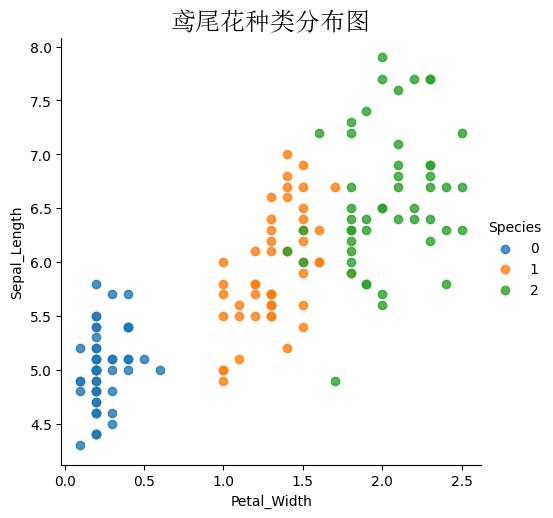

In [10]:
# 把数据转换成dataframe的格式
iris_d = pd.DataFrame(iris['data'], columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
iris_d['Species'] = iris.target

my_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\simsun.ttc',size=18)

def plot_iris(iris, col1, col2):
    sns.lmplot(x = col1, y = col2, data = iris, hue = "Species", fit_reg = False)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('鸢尾花种类分布图',fontproperties=my_font)
    plt.show()
plot_iris(iris_d, 'Petal_Width', 'Sepal_Length')

In [4]:
x_train,x_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=22)
print("x_train:\n", x_train.shape)
# 随机数种子
x_train1, x_test1, y_train1, y_test1 = train_test_split(iris.data, iris.target, random_state=6)
x_train2, x_test2, y_train2, y_test2 = train_test_split(iris.data, iris.target, random_state=6)
print("如果随机数种子不一致：\n", x_train == x_train1)
print("如果随机数种子一致：\n", x_train1 == x_train2)

x_train:
 (112, 4)
如果随机数种子不一致：
 [[False False False False]
 [False False False False]
 [False False False False]
 [ True False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False  True False False]
 [False False False False]
 [False False False False]
 [False False False  True]
 [False  True False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False  True False False]
 [False False False False]
 [False False False False]
 [False False False  True]
 [False False False  True]
 [False False False False]
 [False  True False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False False False False]
 [False  True False False]
 [False False False False]
 [False False False False]
 [False False False Fal

In [5]:
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=22)


In [6]:
transfer = StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)

In [9]:
# 4、机器学习(模型训练)
estimator = KNeighborsClassifier(n_neighbors=9)
estimator.fit(x_train, y_train)
# 5、模型评估
# 方法1：比对真实值和预测值
y_predict = estimator.predict(x_test)
print("预测结果为:\n", y_predict)
print("比对真实值和预测值：\n", y_predict == y_test)
# 方法2：直接计算准确率
score = estimator.score(x_test, y_test)
print("准确率为：\n", score)

预测结果为:
 [0 2 1 2 1 1 1 1 1 0 2 1 2 2 0 2 1 1 1 1 0 2 0 1 2 0 2 2 2 2]
比对真实值和预测值：
 [ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True]
准确率为：
 0.9333333333333333


In [14]:
# 2、数据基本处理 -- 划分数据集
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target,test_size=0.25, random_state=22)
# 3、特征工程：标准化
# 实例化一个转换器类
transfer = StandardScaler()
# 调用fit_transform
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
# 4、KNN预估器流程
#  4.1 实例化预估器类
estimator = KNeighborsClassifier()

In [15]:
# 4.2 模型选择与调优——网格搜索和交叉验证
# 准备要调的超参数
param_dict = {"n_neighbors": [1, 3, 5]}
estimator = GridSearchCV(estimator, param_grid=param_dict, cv=3)
# 4.3 fit数据进行训练
estimator.fit(x_train, y_train)
# 5、评估模型效果
# 方法a：比对预测结果和真实值
y_predict = estimator.predict(x_test)
print("比对预测结果和真实值：\n", y_predict == y_test)
# 方法b：直接计算准确率
score = estimator.score(x_test, y_test)
print("直接计算准确率：\n", score)

比对预测结果和真实值：
 [ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
直接计算准确率：
 0.9473684210526315


In [16]:
print("在交叉验证中验证的最好结果：\n", estimator.best_score_)
print("最好的参数模型：\n", estimator.best_estimator_)
print("每次交叉验证后的准确率结果：\n", estimator.cv_results_)

在交叉验证中验证的最好结果：
 0.9732100521574205
最好的参数模型：
 KNeighborsClassifier()
每次交叉验证后的准确率结果：
 {'mean_fit_time': array([0.0005072 , 0.00016999, 0.        ]), 'std_fit_time': array([4.11267250e-06, 2.40405624e-04, 0.00000000e+00]), 'mean_score_time': array([0.00118438, 0.00136081, 0.0015343 ]), 'std_score_time': array([2.26806993e-04, 2.40012431e-04, 8.88746806e-06]), 'param_n_neighbors': masked_array(data=[1, 3, 5],
             mask=[False, False, False],
       fill_value=999999), 'params': [{'n_neighbors': 1}, {'n_neighbors': 3}, {'n_neighbors': 5}], 'split0_test_score': array([0.97368421, 0.97368421, 0.97368421]), 'split1_test_score': array([0.97297297, 0.97297297, 0.97297297]), 'split2_test_score': array([0.94594595, 0.89189189, 0.97297297]), 'mean_test_score': array([0.96420104, 0.94618303, 0.97321005]), 'std_test_score': array([0.01291157, 0.03839073, 0.00033528]), 'rank_test_score': array([2, 3, 1], dtype=int32)}


预测facebook签到位置

In [17]:
# 1、获取数据集
facebook = pd.read_csv("./data/FBlocation/train.csv")

In [24]:
# 2.基本数据处理
# 2.1 缩小数据范围
facebook_data = facebook.query("x>2.0 & x<2.5 & y>2.0 & y<2.5")
# 2.2 选择时间特征
time = pd.to_datetime(facebook_data["time"], unit="s")
time = pd.DatetimeIndex(time)
facebook_data.insert(facebook_data.shape[1],'day',time.day)
facebook_data.insert(facebook_data.shape[1],'hour',time.hour)
facebook_data.insert(facebook_data.shape[1],'weekday',time.weekday)
# 2.3 去掉签到较少的地方
place_count = facebook_data.groupby("place_id").count()
place_count = place_count[place_count["row_id"]>3]
facebook_data = facebook_data[facebook_data["place_id"].isin(place_count.index)]
# 2.4 确定特征值和目标值
x = facebook_data[["x", "y", "accuracy", "day", "hour", "weekday"]]
y = facebook_data["place_id"]
# 2.5 分割数据集
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.25, random_state=22)

In [25]:
# 3.特征工程--特征预处理(标准化)
# 3.1 实例化一个转换器
transfer = StandardScaler()
# 3.2 调用fit_transform
x_train = transfer.fit_transform(x_train)
x_test = transfer.fit_transform(x_test)

In [26]:
# 4.机器学习--knn+cv
# 4.1 实例化一个估计器
estimator = KNeighborsClassifier()
# 4.2 调用gridsearchCV
param_grid = {"n_neighbors": [1, 3, 5, 7, 9]}
estimator = GridSearchCV(estimator, param_grid=param_grid, cv=5)
# 4.3 模型训练
estimator.fit(x_train, y_train)

C:\Users\XH\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]})

In [27]:
# 5.模型评估
# 5.1 基本评估方式
score = estimator.score(x_test, y_test)
print("最后预测的准确率为:\n", score)

y_predict = estimator.predict(x_test)
print("最后的预测值为:\n", y_predict)
print("预测值和真实值的对比情况:\n", y_predict == y_test)

# 5.2 使用交叉验证后的评估方式
print("在交叉验证中验证的最好结果:\n", estimator.best_score_)
print("最好的参数模型:\n", estimator.best_estimator_)
print("每次交叉验证后的验证集准确率结果和训练集准确率结果:\n",estimator.cv_results_)

最后预测的准确率为:
 0.36567336567336567
最后的预测值为:
 [9983648790 6329243787 9674001925 ... 2990018952 4830766946 7065571836]
预测值和真实值的对比情况:
 24703810     True
19445902    False
18490063     True
7762709     False
6505956     False
            ...  
27632888    False
23367671    False
6692268      True
25834435    False
13319005    False
Name: place_id, Length: 17316, dtype: bool
在交叉验证中验证的最好结果:
 0.3546044971864908
最好的参数模型:
 KNeighborsClassifier(n_neighbors=1)
每次交叉验证后的验证集准确率结果和训练集准确率结果:
 {'mean_fit_time': array([0.03263931, 0.03156557, 0.03108482, 0.0313374 , 0.03133707]), 'std_fit_time': array([0.00175427, 0.0003826 , 0.00025866, 0.00024515, 0.00073584]), 'mean_score_time': array([0.17419848, 0.19390264, 0.21186366, 0.22156343, 0.23302646]), 'std_score_time': array([0.00600373, 0.00210725, 0.00232331, 0.00041836, 0.00375995]), 'param_n_neighbors': masked_array(data=[1, 3, 5, 7, 9],
             mask=[False, False, False, False, False],
       fill_value=999999), 'params': [{'n_neighbors': 1}, {'n_n